<a href="https://colab.research.google.com/github/amiralitah/COCO-CNN-Image-Classification/blob/main/Capstone_Project_Kickoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
import os

In [3]:
# Create coco directory
!mkdir -p coco

# Download the datasets
!cd coco && wget -nc http://images.cocodataset.org/zips/train2017.zip
!cd coco && wget -nc http://images.cocodataset.org/zips/val2017.zip
!cd coco && wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Unzip the files
!cd coco && unzip train2017.zip
!cd coco && unzip val2017.zip
!cd coco && unzip annotations_trainval2017.zip

# List the contents of the coco directory to verify
!ls coco
!ls coco/annotations

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/000000197004.jpg  
 extracting: val2017/000000526751.jpg  
 extracting: val2017/000000041488.jpg  
 extracting: val2017/00000015

In [4]:
# Define transformation for the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Define paths
root_dir = 'coco/'
train_data_dir = os.path.join(root_dir,'train2017/')
val_data_dir =os.path.join(root_dir,'val2017/')
train_ann_file =os.path.join( root_dir, 'annotations/instances_train2017.json')
val_ann_file = os.path.join(root_dir , 'annotations/instances_val2017.json')

#check the directories exist

assert os.path.exists(train_data_dir)
assert os.path.exists(val_data_dir)
assert os.path.exists(train_ann_file)
assert os.path.exists(val_ann_file)
# Load the COCO dataset
train_dataset = CocoDetection(root=train_data_dir, annFile=train_ann_file, transform=transform)
val_dataset = CocoDetection(root=val_data_dir, annFile=val_ann_file, transform=transform)


def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets


subset_size = 5000  # Reduced subset size for faster training  #used to be 2000
batch_size = 64  # Increased batch size if GPU memory allows
num_workers = 4

train_subset = Subset(train_dataset, range(subset_size))
val_subset = Subset(val_dataset, range(1000))  #used to be 500

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)


loading annotations into memory...
Done (t=27.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride= 1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512,91) # COCO dataset has 91 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        #x = self.fc2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNNModel()   #model=CNNmodel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=91, bias=True)
)

In [6]:
#training the model
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  #used to be 0.001

# Training loop
num_epochs = 3 #used to be 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = torch.stack(images).to(device)
        targets = torch.tensor([target[0]['category_id'] if target else -1 for target in targets]).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

Epoch 1, Loss: 3.8707264194005653
Epoch 2, Loss: 3.701014467432529
Epoch 3, Loss: 3.6458096413672725


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for images, targets in val_loader:
        images = torch.stack(images).to(device)
        targets = torch.tensor([target[0]['category_id'] if target else -1 for target in targets]).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
print(f'Validation Accuracy: {100 * correct / total}%')

Validation Accuracy: 20.4%


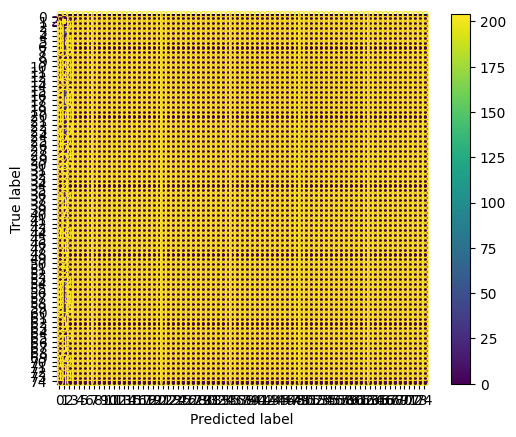

In [10]:
#Test loop + Confusion Matrix
model.eval()
all_targets = []
all_predictions = []
with torch.no_grad():
    for images, targets in val_loader:
        images = torch.stack(images).to(device)
        targets = torch.tensor([target[0]['category_id'] if target else -1 for target in targets]).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()